In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [2]:
#!pip install opencv-python

In [3]:
# Creating file path for our train data and test data
train_dir = r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\train"
test_dir = r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\test"

In [4]:
# Getting 'Autistic' and 'Non-Autistic' train images from respective file names of train data
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in (r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\train\{}".format(i)):
        train_non_autistic.append((r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\train\{}".format(i)))
    else:
        train_autistic.append((r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\train\{}".format(i)))
        
# Getting test images from test data file path
test_imgs = [r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\test/{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()


57

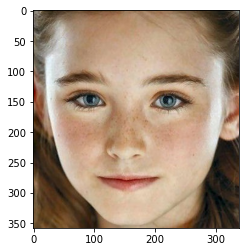

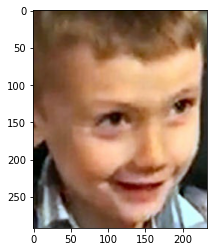

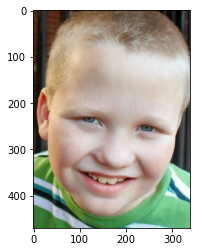

In [5]:
# Plot first 3 images from train_imgs
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()


In [6]:
# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

In [7]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

# Delete train images to save space
del train_imgs
gc.collect()

6084

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Train image labels')

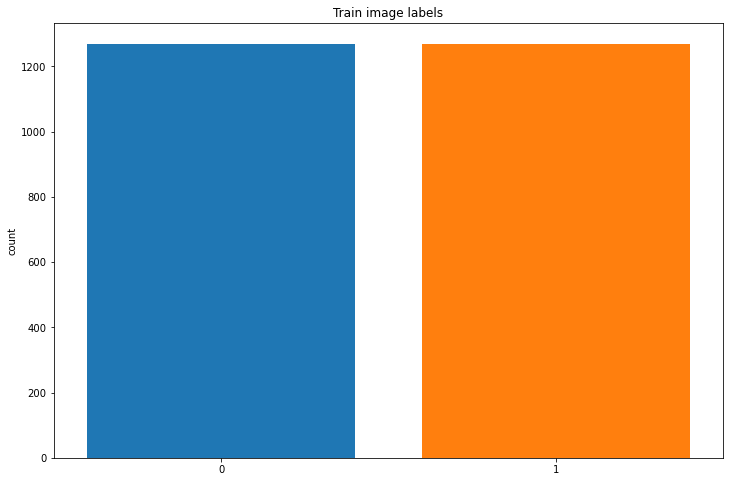

In [8]:
# Convert the lists to array
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)
sns.countplot(y_train, saturation=1)
plt.title("Train image labels")

In [9]:
# Shape of train images and labels
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [10]:
# Repeat the above process for validation data to get val_images
val_autistic = r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\valid\Autistic"
val_non_autistic = r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\valid\Non_Autistic"
val_autistic_imgs = [r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\valid\Autistic\{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = [r"C:\Users\Soft Zone\Downloads\Compressed\AutismDataset\valid\Non_Autistic\{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

0

In [11]:
# Get resized images and labels from validation data
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

0

In [13]:
# Shape of validation images and labels
#print("Shape of validation images:", X_val.shape)
#print("Shape of validation labels:", y_val.shape)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Validation image labels')

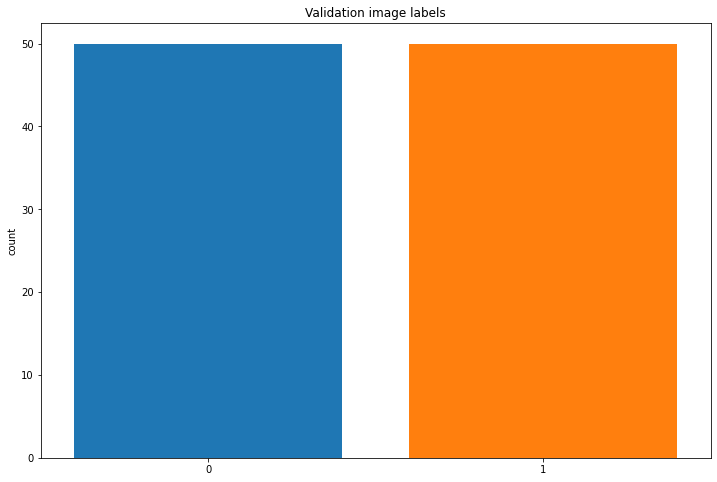

In [14]:
# Convert the lists to array
plt.figure(figsize=(12, 8))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

In [15]:
# Get length of train data and validation data
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

In [16]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

In [17]:
# Freeze the layers in pre-trained model, we don't need to train again
for layer in base_model.layers:
   layer.trainable = False

In [18]:
# Let's see how many layers are in the vgg model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [19]:
# Create our classifier model, connect pre-trained model vgg to our model
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [20]:
# Create summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
# Compile the model specifying optimizer, loss function and metrics
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['acc'])

In [22]:
# Configure data augumentation and scaling of images to prevent overfitting since we have a small train data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
# Create test and validation image generator
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size = batch_size)

In [24]:
# Train the model
history = model.fit(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=40,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size
                             )

Epoch 1/40
79/79 [==============================] - 345s 4s/step - loss: 0.7044 - acc: 0.6419 - val_loss: 0.5733 - val_acc: 0.6875
Epoch 2/40
79/79 [==============================] - 346s 4s/step - loss: 0.5565 - acc: 0.7109 - val_loss: 0.5299 - val_acc: 0.7500
Epoch 3/40
79/79 [==============================] - 344s 4s/step - loss: 0.5476 - acc: 0.7165 - val_loss: 0.5720 - val_acc: 0.6771
Epoch 4/40
79/79 [==============================] - 345s 4s/step - loss: 0.5259 - acc: 0.7380 - val_loss: 0.4946 - val_acc: 0.7708
Epoch 5/40
79/79 [==============================] - 347s 4s/step - loss: 0.5155 - acc: 0.7416 - val_loss: 0.5291 - val_acc: 0.7292
Epoch 6/40
79/79 [==============================] - 348s 4s/step - loss: 0.5234 - acc: 0.7360 - val_loss: 0.6115 - val_acc: 0.6562
Epoch 7/40
79/79 [==============================] - 352s 4s/step - loss: 0.5201 - acc: 0.7285 - val_loss: 0.5319 - val_acc: 0.7396
Epoch 8/40
79/79 [==============================] - 355s 4s/step - loss: 0.4942 - a

In [25]:
# Learning curves for training and validation
history_df = pd.DataFrame(history.history)
history_df

,loss,acc,val_loss,val_acc
0,0.704374,0.641946,0.573291,0.687500
1,0.556506,0.710925,0.529851,0.750000
2,0.547610,0.716507,0.571976,0.677083
3,0.525856,0.738038,0.494623,0.770833
4,0.515454,0.741627,0.529119,0.729167
5,0.523444,0.736045,0.611499,0.656250
6,0.520104,0.728469,0.531915,0.739583
7,0.494240,0.753588,0.511528,0.718750
8,0.508552,0.744418,0.524224,0.739583
9,0.492103,0.748006,0.489659,0.697917


Text(0.5, 1.0, 'Training and Validation Accuracy')

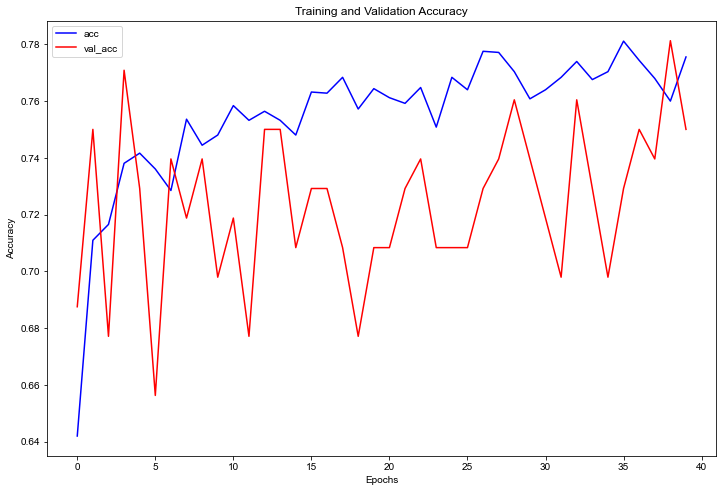

In [26]:
# Plot train and validation accuracy
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

In [27]:
# Read and resize test images
random.shuffle(test_imgs)
X_test, y_test = read_and_process_image(test_imgs)
X = np.array(X_test)
#test_datagen = ImageDataGenerator(rescale = 1./255)

In [28]:
# Predict label for test images
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)
#print(predictions)

10/10 [==============================] - 32s 3s/step


In [29]:
# Plot test images and their corresponding predictions
test = pd.DataFrame(data = predictions, columns = ["predictions"])
test
test["filename"] = [os.path.basename(i) for i in test_imgs]
test["test_labels"] = y_test
test = test[["filename", "test_labels", "predictions"]]
test

,filename,test_labels,predictions
0,Autistic.136.jpg,1,0
1,Autistic.26.jpg,1,1
2,Non_Autistic.148.jpg,0,0
3,Non_Autistic.2.jpg,0,0
4,Autistic.129.jpg,1,1
...,...,...,...
295,Non_Autistic.66.jpg,0,0
296,Autistic.5.jpg,1,1
297,Non_Autistic.47.jpg,0,0
298,Autistic.102.jpg,1,0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='count'>

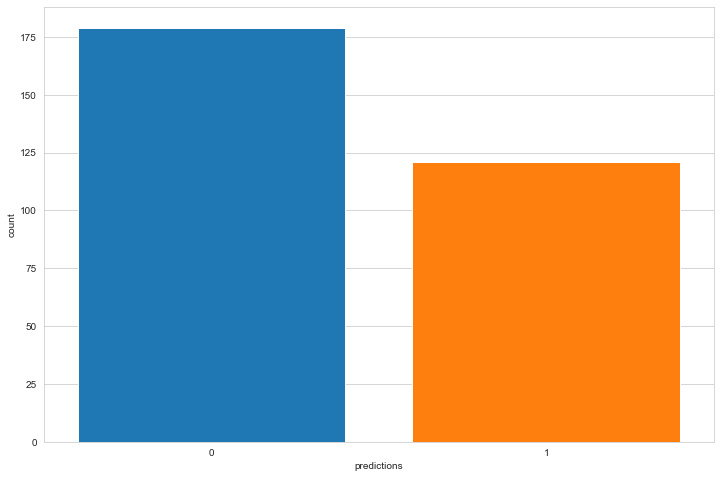

In [30]:
# Plotting the predictied label count in each class
plt.figure(figsize=(12, 8))
sns.countplot(test["predictions"], saturation=1)

In [31]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))

Model Accuracy: 75.00%


In [32]:
# Generating Classification report for model's performance in each class
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       150
           1       0.81      0.65      0.72       150

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300



In [33]:
# Generating Confusion Matrix for the predictions against true labels
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[127,  23],
       [ 52,  98]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

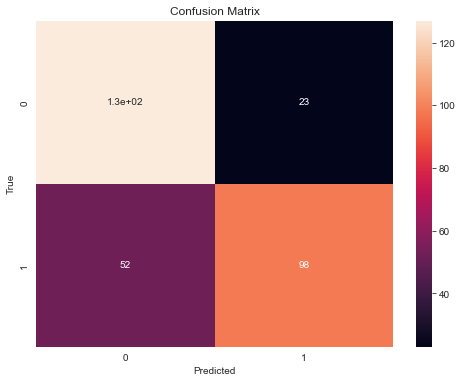

In [34]:
# Plotting the True Positives, True Negatives, False Positives and False Negatives from model's predictions
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [35]:
# Let's plot the AUC-ROC curve to assess the performance of our model
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc= auc(fpr, tpr)

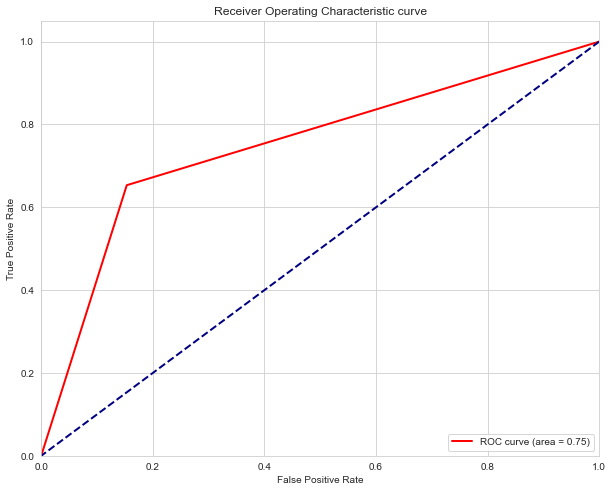

In [36]:
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([1,0], [1,0], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc = 'lower right')

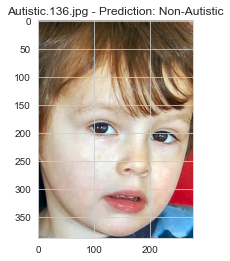

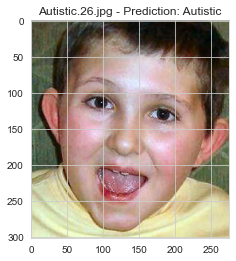

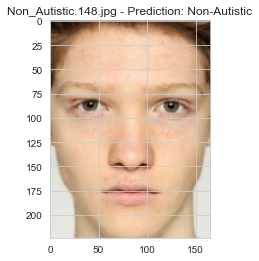

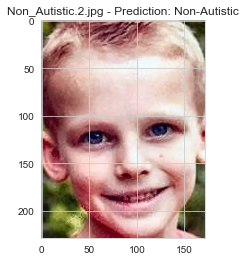

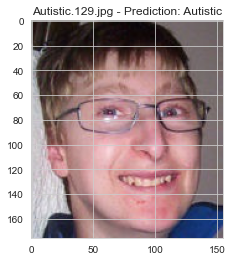

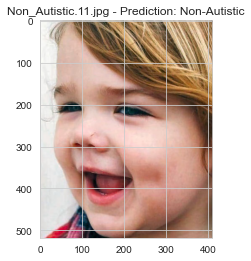

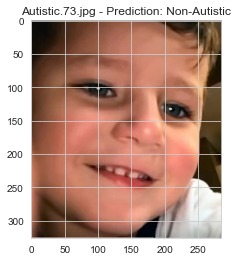

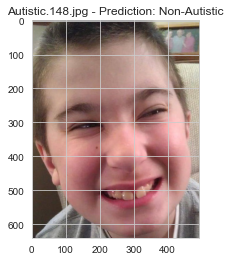

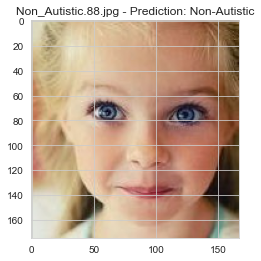

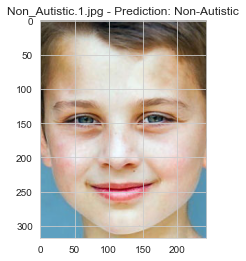

In [37]:
# Let's check our predcitions against some test images
plt.figure(figsize=(4,4))
for val, i in enumerate(test_imgs[:10]):
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.title(os.path.basename(i) + ' - Prediction: ' +  f"{'Autistic' if predictions[val] == 1 else 'Non-Autistic'}")
    plt.show() 

In [38]:
model.save("images.h5")
print("saved model")

saved model
